### 数据集

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torch import nn
from torch.utils.data import Subset # for sub dataset
from geo import get_classified_dataset, get_dataset_geo_feature
from app_utils import dataset_compress

import utils
import network


In [2]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, '..', 'dataset')
print(dataset_dir)
print(torch.__version__)

/home/hhw/geo/hhw_code/../dataset
2.0.1+cu117


In [3]:
# test gpu
num_gpus = torch.cuda.device_count()
current_gpu_index = torch.cuda.current_device()
gpu_name = torch.cuda.get_device_name(current_gpu_index)
gpu_name

'NVIDIA GeForce RTX 3050 Laptop GPU'

#### 加载数据集

In [4]:
# def flatten_transform(image):
#     return image.view(-1)
transform1 = transforms.Compose([
    transforms.ToTensor(),
    lambda image: image.reshape(-1)
])

dataset_name = 'mnist'

mnist_trainset = torchvision.datasets.MNIST(
    root=dataset_dir, train = True, download = False, transform = transform1)

mnist_testset = torchvision.datasets.MNIST(
    root = dataset_dir, train = False, download = True, transform = transform1)


#### 截取部分数据做测试

In [5]:
train_size = 1000
test_size = 10000
k = 8

In [6]:
mnist_trainset = Subset(mnist_trainset, range(train_size))
mnist_testset = Subset(mnist_testset, range(test_size))

In [7]:
len(mnist_trainset.dataset)
# len(classified_dataset[0])

60000

In [8]:
# 将数据分类存放
classified_dataset = get_classified_dataset(mnist_trainset)

In [9]:
# 获取训练集 几何特征
each_class_feature, egr_scope, uhop_scope = get_dataset_geo_feature(classified_dataset, k=k)


KeyboardInterrupt: 

In [21]:
each_class_feature = dict(each_class_feature)

In [22]:
type(each_class_feature), type(egr_scope), type(uhop_scope)

(dict, numpy.ndarray, numpy.ndarray)

In [23]:
mnist_trainset.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/hhw/geo/hhw_code/../dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f886e6840e0>
           )

In [29]:
# save to file
dataset_name = 'mnist'

import pickle
results_dir = os.path.join(cwd, 'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
geo_feature_path = os.path.join(results_dir, f'geo_{dataset_name}_trsz{train_size}_tesz{test_size}_k{k}.pkl')

with open(geo_feature_path, 'wb') as f:
    pickle.dump(each_class_feature, f)
    pickle.dump(egr_scope, f)
    pickle.dump(uhop_scope, f)

In [30]:
# read from file
with open(geo_feature_path, 'rb') as f:
    each_class_feature = pickle.load(f)
    egr_scope = pickle.load(f)
    uhop_scope = pickle.load(f)

In [40]:
for key in each_class_feature[0].keys():
    if key == 'label':
        continue
    print(key)
    print(type(each_class_feature[0][key]), end=', ')
    try:
        print(each_class_feature[0][key].shape)
    except:
        print(len(each_class_feature[0][key]))
    print()

path_avg_egr
<class 'numpy.ndarray'>, (479, 479)

path_dict
<class 'dict'>, 114481

geodesic_dist
<class 'numpy.ndarray'>, (479, 479)

bone_path_index
<class 'numpy.ndarray'>, (479, 479)

bone_weight
<class 'numpy.ndarray'>, (479,)

class_ave_egr
<class 'numpy.ndarray'>, (2,)

class_uhop
<class 'numpy.ndarray'>, (2,)



#### 数据压缩/增强

In [11]:
# 获取 egr, uhop 阈值
egr_threshold = (egr_scope[0] + egr_scope[1]) / 2.0
uhop_threshold = (uhop_scope[0] + uhop_scope[1]) / 2.0

rate = 0.1

In [12]:
s_res_dataset, s_removed_dataset = dataset_compress(classified_dataset = classified_dataset,
                                                    each_class_feature = each_class_feature,
                                                    rate = rate, 
                                                    egr_threshold = egr_threshold, 
                                                    uhop_threshold = uhop_threshold)

dataset_compress, label: 5, shape: torch.Size([434, 784])
dataset_compress, label: 0, shape: torch.Size([479, 784])
dataset_compress, label: 4, shape: torch.Size([535, 784])
dataset_compress, label: 1, shape: torch.Size([563, 784])
dataset_compress, label: 9, shape: torch.Size([495, 784])
dataset_compress, label: 2, shape: torch.Size([488, 784])
dataset_compress, label: 3, shape: torch.Size([493, 784])
dataset_compress, label: 6, shape: torch.Size([501, 784])
dataset_compress, label: 7, shape: torch.Size([550, 784])
dataset_compress, label: 8, shape: torch.Size([462, 784])


#### 测试数据压缩/增强的效果

In [13]:
# ToDo
res_data_X = torch.cat(list(s_res_dataset.values()), dim=0)
res_data_y = torch.cat([torch.ones(len(s_res_dataset[label]), dtype=torch.long) * label for label in s_res_dataset.keys()], dim=0)
# res_dataset = data.TensorDataset(res_data_X.reshape((-1, 1, 28, 28)), res_data_y)
res_dataset = data.TensorDataset(res_data_X, res_data_y)


In [14]:
batch_size = 256
from dataset import get_num_cores

origin_train_iter = data.DataLoader(mnist_trainset, batch_size, shuffle=True, num_workers=get_num_cores())
res_train_iter = data.DataLoader(res_dataset, batch_size, shuffle=True, num_workers=get_num_cores())
test_iter = data.DataLoader(mnist_testset, batch_size, shuffle=False, num_workers=get_num_cores())
for X, y in origin_train_iter:
    print(X.shape)
    print(y.shape)
    break

for X, y in res_train_iter:
    print(X.shape)
    print(y.shape)
    break

for X, y in test_iter:
    print(X.shape)
    print(y.shape)
    break


num_cores:  16
num_cores:  16
num_cores:  16
torch.Size([256, 784])
torch.Size([256])
torch.Size([256, 784])
torch.Size([256])
torch.Size([256, 784])
torch.Size([256])


In [15]:
len(mnist_trainset.dataset)

60000

In [16]:
# train and test
lr, num_epochs = 1.1, 80
device = utils.try_gpu()
origin_lenet = network.LeNet
res_lenet = network.LeNet



In [17]:
def set_seed(seed: int):
    torch.manual_seed(seed) # 为CPU设置随机种子
    torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU，为所有GPU设置随机种子
    # np.random.seed(seed) # Numpy module.
    # random.seed(seed) # Python random module.
set_seed(42)

: 

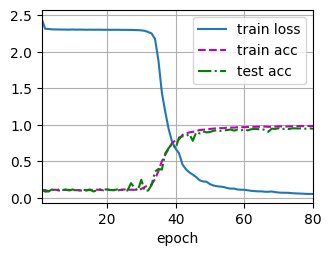

In [18]:
origin_lenet = network.train(origin_lenet, origin_train_iter, test_iter, num_epochs, lr, device)

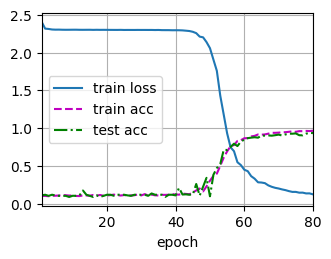

In [19]:
res_lenet = network.train(res_lenet, res_train_iter, test_iter, num_epochs, lr, device)


#### 其他

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/home/hhw/geo_feature/hhw_code
/home/hhw/geo_feature/hhw_code/dataset
num_cores:  16
num_cores:  16


In [11]:
a1 = torch.tensor([[-1.0356,  2.0356]])
a1.fill_diagonal_(fill_value=0)

tensor([[0.0000, 2.0356]])

In [2]:
# Python program explaining
# where() function

import numpy as np

# a is an array of integers.
a = np.array([[1, 0, 3], [4, 5, 6]])

print(a)

print ('Indices of elements <4')

b = np.where(a == 0, 11, a)
print(b)




[[1 0 3]
 [4 5 6]]
Indices of elements <4
[[ 1 11  3]
 [ 4  5  6]]
Elements which are <4


IndexError: index 11 is out of bounds for axis 0 with size 2

In [43]:

from torch import nn
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        # print(self.shape)
        return x.reshape(self.shape)

net = nn.Sequential(
    Reshape(-1, 1, 28, 28),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid()
)
X = torch.tensor([])
for X, y in origin_train_iter:
    print(X.shape)
    print(y.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([256, 784])
torch.Size([256])
torch.Size([256, 784])
torch.Size([256])
torch.Size([232, 784])
torch.Size([232])


In [44]:
a = X.reshape((-1, 1, 28, 28))
a.shape
print(X.shape)
b = net(X)
print(b.shape)

torch.Size([232, 784])
torch.Size([232, 6, 28, 28])
